In [1]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(0)

# Disable logging messages unless there is an error
set_log_level("ERROR")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Series.view is deprecated")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [37]:
def reformat_forecast(forecast):
  forecast_data = []

  for i in range(8):
      step_col = f"step{i}"
      quantile_20_col = f"step{i} 20.0%"  # Column name for 20th percentile
      quantile_80_col = f"step{i} 80.0%"  # Column name for 80th percentile


      forecast_data.append({
          "ds": forecast["ds"].iloc[-1] + pd.Timedelta(hours=i),
          "yhat": forecast[step_col].iloc[-1],
          "yhat_lower": forecast[quantile_20_col].iloc[-1],  # Add lower bound (20th percentile)
          "yhat_upper": forecast[quantile_80_col].iloc[-1]   # Add upper bound (80th percentile)
      })

  new_forecast_df = pd.DataFrame(forecast_data)
  return new_forecast_df

In [19]:
# data = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
data = pd.read_csv('https://www.dropbox.com/scl/fi/s83jig4zews1xz7vhezui/allDataWithCalculatedColumns.csv?rlkey=9mm4zwaugxyj2r4ooyd39y4nl&raw=1')
data.ds = pd.to_datetime(data.ds)
data = data.sort_values('ds')
# data['y']=data['POD_GREEN_TBS']+data['POD_YELLOW_TBS']+data['POD_ORANGE_TBS']+data['TRG_HALLWAY_TBS']+data['RAZ_TBS']+data['AMBVERTTBS']+data['QTrack_TBS']+data['Garage_TBS']
data['y']=data['total_tbs']
df= data.copy()
# regressors='Inflow_Total'
# regressors = df.columns.tolist()
# regressors.remove('y')
# regressors.remove('ds')
# for col in regressors:
#     try:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#     except (ValueError, TypeError):
#         print(f"Warning: Could not convert column '{col}' to numeric. Skipping...")
# df = df[['ds','y', 'Inflow_Total']]
df.tail()


,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow,y
42195,2025-10-28 09:00:00,13,45,4,9,17,54,1,9,0,...,0,2,2,14,12,10,9,1,10,10
42196,2025-10-28 10:00:00,6,51,9,18,15,69,1,10,0,...,0,2,2,14,12,10,9,1,11,10
42197,2025-10-28 11:00:00,12,63,9,27,21,90,2,12,0,...,0,2,3,14,12,9,7,2,12,9
42198,2025-10-28 12:00:00,12,75,8,35,20,110,4,16,0,...,0,3,3,13,12,14,7,7,15,14
42199,2025-10-28 13:00:00,16,91,6,41,22,132,5,21,0,...,0,2,1,15,12,19,8,11,23,19


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

   train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
9    0.054475       0.0  5.197389  6.783417  0.054475      0.0      9


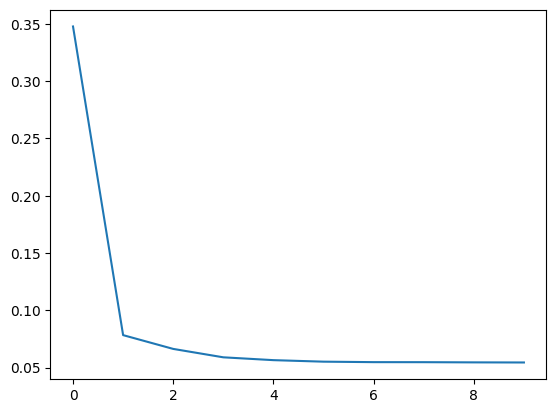

In [23]:
params = {
    'growth':'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs':10,
    # 'changepoints_range': 0.95,
    # 'n_changepoints': 50,
    'quantiles': [0.2, 0.5, 0.8]
    # num_hidden_layers=4,
    # d_hidden=36,
    # learning_rate=0.005,

}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
# m = m.add_lagged_regressor(names=regressors, n_lags=8)
# m = m.add_country_holidays("CA")
set_random_seed(42)
# metrics = m.fit(df, freq='h', progress='plot')
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')


print(metrics.tail(1))

In [33]:
# df_future = m.make_future_dataframe(df, periods=8)
df_future = m.make_future_dataframe(df[['ds','y']], periods=8)
# print(df_future)
# forecast = m.predict(df_future)
forecast = m.predict(df_future, decompose=False, raw=True)
forecast

Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,step0,step0 20.0%,step0 80.0%,step1,step1 20.0%,step1 80.0%,step2,step2 20.0%,step2 80.0%,...,step4 80.0%,step5,step5 20.0%,step5 80.0%,step6,step6 20.0%,step6 80.0%,step7,step7 20.0%,step7 80.0%
0,2025-10-28 13:00:00,18.978323,15.229452,23.733751,22.936110,18.207346,26.675575,27.935190,22.999798,30.869453,...,32.192074,26.211205,21.403954,31.315207,23.306900,17.502905,27.754093,23.494228,19.920847,26.107828
1,2025-10-28 14:00:00,22.347256,17.199106,27.422731,27.359632,22.581184,32.458263,29.959499,25.477058,36.520828,...,31.673702,23.198044,18.515991,26.725033,23.118177,19.949810,27.177095,22.412649,17.674683,27.828133


In [39]:
output_df = reformat_forecast(forecast)
output_df

,ds,yhat,yhat_lower,yhat_upper
0,2025-10-28 14:00:00,22.347256,17.199106,27.422731
1,2025-10-28 15:00:00,27.359632,22.581184,32.458263
2,2025-10-28 16:00:00,29.959499,25.477058,36.520828
3,2025-10-28 17:00:00,28.465923,24.133636,33.669247
4,2025-10-28 18:00:00,26.467524,20.913517,31.673702
5,2025-10-28 19:00:00,23.198044,18.515991,26.725033
6,2025-10-28 20:00:00,23.118177,19.949810,27.177095
7,2025-10-28 21:00:00,22.412649,17.674683,27.828133


In [45]:
from neuralprophet import save


MODEL_VERSION = 1

save(m, f"../models/total_tbs-{MODEL_VERSION}.np")

In [ ]:
# from neuralprophet import load
MODEL_VERSION = 1
# model = load(f"../models/total_tbs-{MODEL_VERSION}.np")

Training: |          | 0/? [00:00<?, ?it/s]